In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121


In [38]:
import os
disease_types = ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']
data_dir = r'C:\Users\ANITHRA ROSS AJITH\Documents\code\tomato leaf disease\training\New Plant Diseases Dataset(Augmented)\train'
train_dir = os.path.join(data_dir)
#test_dir = os.path.join(data_dir, 'test')train_dir = r'C:\Users\ANITHRA ROSS AJITH\Documents\code\tomato leaf disease\training\New Plant Diseases Dataset(Augmented)\train'


In [37]:
print("Folders in train_dir:", os.listdir(train_dir))


Folders in train_dir: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']


In [39]:
import os
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.tail()

,File,DiseaseID,Disease Type
18340,Tomato___Tomato_Yellow_Leaf_Curl_Virus/ffb295c...,9,Tomato___Tomato_Yellow_Leaf_Curl_Virus
18341,Tomato___Tomato_Yellow_Leaf_Curl_Virus/ffe08cc...,9,Tomato___Tomato_Yellow_Leaf_Curl_Virus
18342,Tomato___Tomato_Yellow_Leaf_Curl_Virus/ffe996e...,9,Tomato___Tomato_Yellow_Leaf_Curl_Virus
18343,Tomato___Tomato_Yellow_Leaf_Curl_Virus/fff42f1...,9,Tomato___Tomato_Yellow_Leaf_Curl_Virus
18344,Tomato___Tomato_Yellow_Leaf_Curl_Virus/fff6bf8...,9,Tomato___Tomato_Yellow_Leaf_Curl_Virus


In [40]:
for defects_id, sp in enumerate(disease_types):
    full_path = os.path.join(train_dir, sp)
    print(f"Checking path: {full_path}")
    for file in os.listdir(full_path):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])


Checking path: C:\Users\ANITHRA ROSS AJITH\Documents\code\tomato leaf disease\training\New Plant Diseases Dataset(Augmented)\train\Tomato___Bacterial_spot
Checking path: C:\Users\ANITHRA ROSS AJITH\Documents\code\tomato leaf disease\training\New Plant Diseases Dataset(Augmented)\train\Tomato___Early_blight
Checking path: C:\Users\ANITHRA ROSS AJITH\Documents\code\tomato leaf disease\training\New Plant Diseases Dataset(Augmented)\train\Tomato___healthy
Checking path: C:\Users\ANITHRA ROSS AJITH\Documents\code\tomato leaf disease\training\New Plant Diseases Dataset(Augmented)\train\Tomato___Late_blight
Checking path: C:\Users\ANITHRA ROSS AJITH\Documents\code\tomato leaf disease\training\New Plant Diseases Dataset(Augmented)\train\Tomato___Leaf_Mold
Checking path: C:\Users\ANITHRA ROSS AJITH\Documents\code\tomato leaf disease\training\New Plant Diseases Dataset(Augmented)\train\Tomato___Septoria_leaf_spot
Checking path: C:\Users\ANITHRA ROSS AJITH\Documents\code\tomato leaf disease\train

In [41]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Tomato___Spider_mites Two-spotted_spider_mite/...,6,Tomato___Spider_mites Two-spotted_spider_mite
1,Tomato___healthy/2fd78b0f-a307-4824-9e6c-ff4a3...,2,Tomato___healthy
2,Tomato___Septoria_leaf_spot/4b0ff251-1da4-4f9c...,5,Tomato___Septoria_leaf_spot
3,Tomato___Spider_mites Two-spotted_spider_mite/...,6,Tomato___Spider_mites Two-spotted_spider_mite
4,Tomato___Tomato_Yellow_Leaf_Curl_Virus/bddb49e...,9,Tomato___Tomato_Yellow_Leaf_Curl_Virus


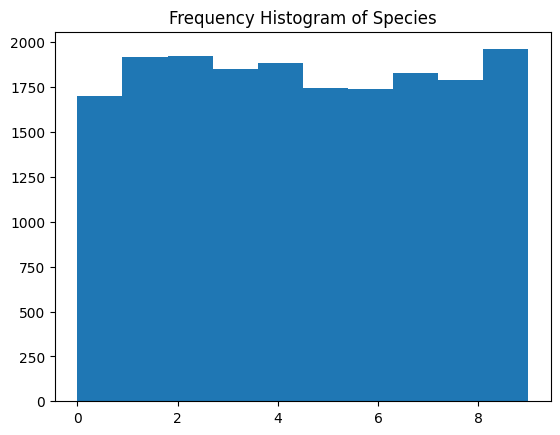

<Figure size 1200x1200 with 0 Axes>

In [42]:
# Plot a histogram
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

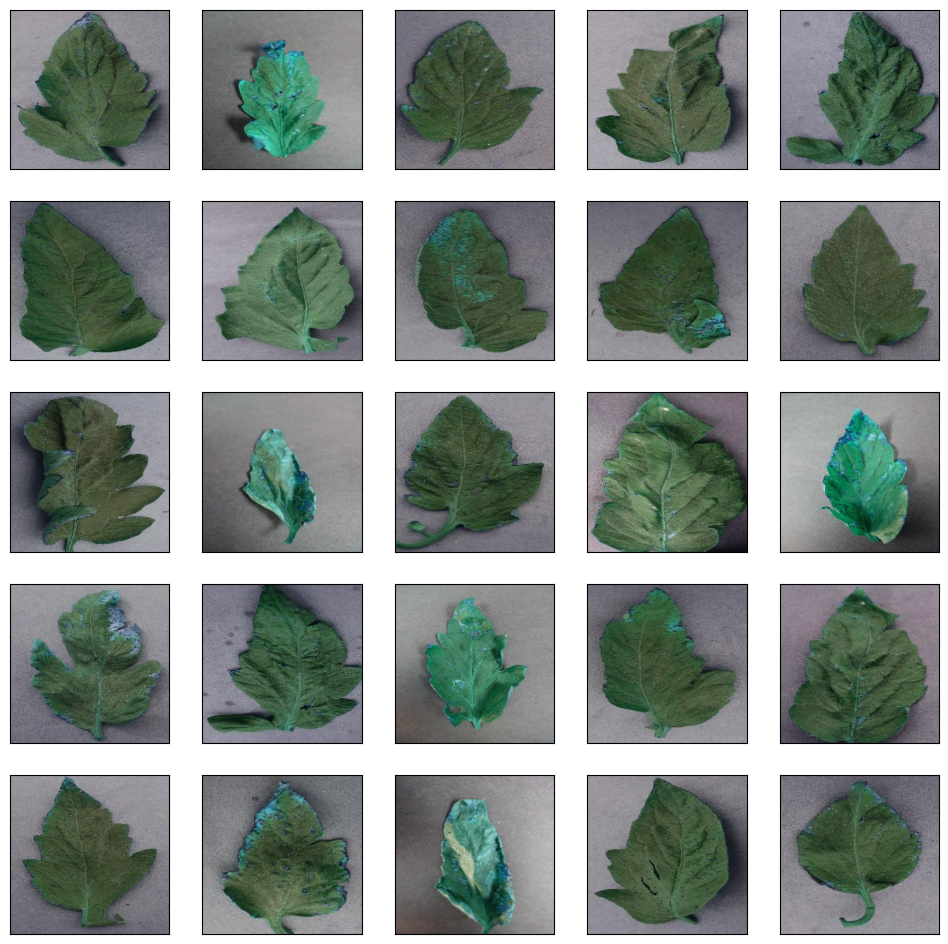

In [51]:
# Display images for different species
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('Tomato___Bacterial_spot', 5, 5)

In [52]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [53]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

18345it [03:00, 101.46it/s]


Train Shape: (18345, 64, 64, 3)


In [54]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=10)

In [55]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

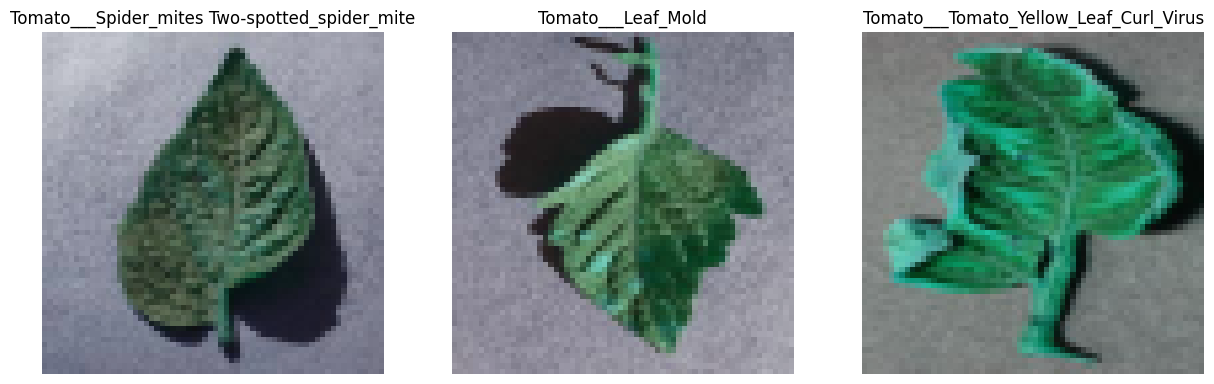

In [56]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [57]:
EPOCHS = 50
SIZE=64
N_ch=3

In [63]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(10,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


    model.summary()
    
    return model

In [66]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
model = build_densenet()

annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.keras', verbose=1, save_best_only=True)

# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
                 steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                 epochs=EPOCHS,
                 verbose=2,
                 callbacks=[annealer, checkpoint],
                 validation_data=(X_val, Y_val))


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 3)           │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 2, 2, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ root (Dense)                         │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,307,678 (27.88 MB)

 Trainable params: 7,221,470 (27.55 MB)

 Non-trainable params: 86,208 (336.75 KB)

C:\Users\ANITHRA ROSS AJITH\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50

Epoch 1: val_loss improved from inf to 1.45804, saving model to model.keras
229/229 - 347s - 2s/step - accuracy: 0.2813 - loss: 2.5291 - val_accuracy: 0.4977 - val_loss: 1.4580 - learning_rate: 0.0020
Epoch 2/50


C:\Users\ANITHRA ROSS AJITH\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 2: val_loss improved from 1.45804 to 1.45755, saving model to model.keras
229/229 - 20s - 88ms/step - accuracy: 0.5312 - loss: 1.5431 - val_accuracy: 0.4990 - val_loss: 1.4575 - learning_rate: 0.0020
Epoch 3/50

Epoch 3: val_loss improved from 1.45755 to 0.92552, saving model to model.keras
229/229 - 239s - 1s/step - accuracy: 0.6374 - loss: 1.1095 - val_accuracy: 0.7040 - val_loss: 0.9255 - learning_rate: 0.0020
Epoch 4/50

Epoch 4: val_loss improved from 0.92552 to 0.91422, saving model to model.keras
229/229 - 16s - 70ms/step - accuracy: 0.7188 - loss: 0.8014 - val_accuracy: 0.7084 - val_loss: 0.9142 - learning_rate: 0.0020
Epoch 5/50

Epoch 5: val_loss improved from 0.91422 to 0.68450, saving model to model.keras
229/229 - 238s - 1s/step - accuracy: 0.7822 - loss: 0.6468 - val_accuracy: 0.7760 - val_loss: 0.6845 - learning_rate: 0.0020
Epoch 6/50

Epoch 6: val_loss did not improve from 0.68450
229/229 - 14s - 61ms/step - accuracy: 0.8281 - loss: 0.4120 - val_accuracy: 0.7602

In [67]:
#model = load_model('../output/kaggle/working/model.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

115/115 ━━━━━━━━━━━━━━━━━━━━ 18s 152ms/step - accuracy: 0.9633 - loss: 0.1057
Final Loss: 0.11168671399354935, Final Accuracy: 0.9648405313491821


In [4]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(5, 5))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=10)
ax.set_xlabel('Predicted', fontsize=10)

NameError: name 'model' is not defined

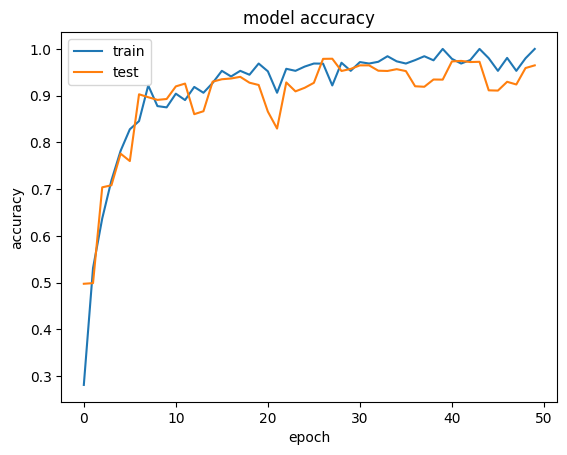

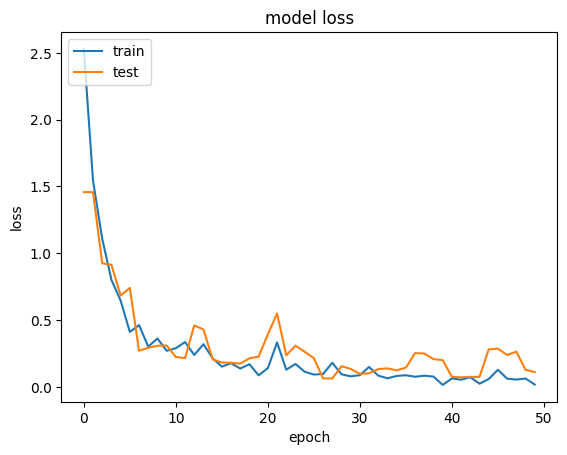

In [69]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Image loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
[2.9105140e-04 8.6968213e-01 6.2681079e-02 7.0700841e-03 4.1625514e-03
 2.1784984e-02 1.5737068e-04 1.2782962e-02 2.1355869e-02 3.1793857e-05]


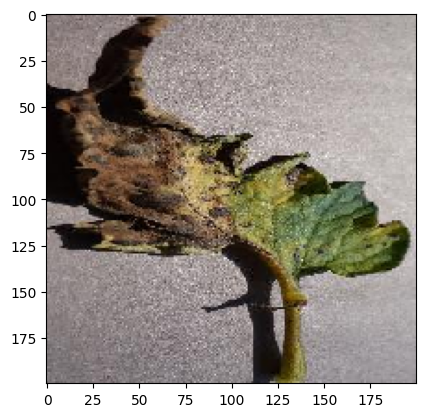

Prediction: Tomato___Early_blight


In [76]:
from skimage import io
from keras.preprocessing import image

path = r'C:\Users\ANITHRA ROSS AJITH\Documents\code\tomato leaf disease\training\test\test\TomatoEarlyBlight1.jpg'
if os.path.exists(path):
    img = image.load_img(path, color_mode='rgb', target_size=(64, 64))
    show_img = image.load_img(path, color_mode='rgb', target_size=(200, 200))
    print("Image loaded successfully.")
else:
    print("File not found at the specified path.")

disease_class = [
    'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 
    'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 
    'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 
    'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus'
]

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
#x = np.array(x, 'float32')
x /= 255

custom = model.predict(x)
print(custom[0])



#x = x.reshape([64, 64]);

#plt.gray()
plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])